# Introduction

In this notebook, we will learn about unsupervised methods for clustering and dimensionality reduction.

## Table of Content

- [0. Packages](#0)
- [1. Unsupervised Leearning](#1)
- [2. Dataset](#2)
- [3. Dimensionality Reduction](#3)
    - [3.1 PCA](#3-1)
    - [3.2 LDA](#3-2)
    - [3.3 NMF](#3-3)
    - [3.4 Kernel PCA](#3-4)
    - [3.5 tSNE](#3-5)
    - [3.6 ISOMAP](#3-6)
    - [3.7 UMAP](#3-7)
- [4. Clustering](#4)
    - [4.1. KMeans](#4-1)
    - [4.2. DBScan](#4-2)


# 0. Packages <a name="0"></a>

In this session, we will make use of the following packages:
- [PathLib](https://docs.python.org/3/library/pathlib.html) is a convenient library to work with path names.
- [NumPy](https://docs.scipy.org/doc/numpy/) is a popular library for scientific computing.
- [matplotlib](https://matplotlib.org/3.1.1/contents.html) is a plotting library compatible with numpy.
- [pandas](https://pandas.pydata.org/docs/) is what we'll use to manipulate our data.
- [sklearn](https://scikit-learn.org/stable/index.html) will be used to measure the performance of our model.

Run the next cell to import the necessary packages mentioned before. Besides, we will add more packages as needed while progressing in this session.

In [1]:
# Good practice to use short but clear aliases for the imported libraries
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
# For 3d plotting
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import sklearn
# Magic Function
%matplotlib inline
# Hide all warnings
import warnings
warnings.filterwarnings('ignore') # warnings.filterwarnings(action='once')

<a name="1"></a>
# 1. Unsupervised Learning

Unsupervised learning is one of the types of machine learning techniques where the aim is to find patterns in the data without any pre-existent labels (unlike supervised learning).


Unsupervised learning is used for two main task:

- Dimensionality Reduction: Reduce the number of features trying to retain as much information possible.
- Cluster Analysis: Cluster data with similar features.


<a name="2"></a>
## 2 Dataset

In this session, we will be using the GeoLink dataset that used in previous sessions.

**Note:** download data from https://drive.google.com/drive/folders/1EgDN57LDuvlZAwr5-eHWB5CTJ7K9HpDP

Credit to this repo: https://github.com/LukasMosser/geolink_dataset

## Data Disclaimer

All the data serving as an input to these notebooks was generously donated by GEOLINK  
and is CC-by-SA 4.0 

If you use this data please reference the dataset properly to give them credit for their contribution.


## Data Preparation
The geolink dataset we will use in this notebook has been preprocessed. You can find the process of preparation of this dataset in <code>notebook/00 Data Prep/00-mc-prep_geolink_norge_dataset.ipynb</code>

## Load Dataset

Let's load the dataset

In [2]:
interim_locations = Path("../../data/processed/geolink_norge_dataset/")
# Load processed dataset
geolink = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
geolink

LITHOLOGY_GEOLINK       CALI      DRHO      NPHI  \
Well    DEPT                                                           
15_9-12 2215.917725        Shaly Silt  14.438001  0.010000  0.447725   
        2216.070068        Shaly Silt  14.633000  0.006000  0.432095   
        2216.222412        Shaly Silt  14.813001  0.006000  0.410166   
        2216.375000        Shaly Silt  14.383001 -0.001000  0.414143   
        2216.527344        Shaly Silt  14.202999  0.001000  0.439923   
...                               ...        ...       ...       ...   
7_3-1   2723.585938         Anhydrite   9.157000  0.141856  0.000000   
        2723.738525         Anhydrite   9.197000  0.148906  0.000000   
        2723.890869         Anhydrite   9.236000  0.148817  0.000000   
        2724.043213         Anhydrite   9.262000  0.150856  0.000000   
        2724.195557         Anhydrite   9.268000  0.145638  0.000000   

                         RHOB         GR         DTC         RDEP         SP  \
Well    DEPT                                                                   
15_9-12 2215.917725  2.363000  60.285748  134.253601     0.737006  50.570400   
        2216.070068  2.340000  63.250000  129.101868     0.741000  50.820000   
        2216.222412  2.314000  61.405998  122.476944     0.752000  50.820000   
        2216.375000  2.293000  62.561596  116.908607     0.739962  51.070000   
        2216.527344  2.275000  61.691055  115.390953     0.715966  51.070602   
...                       ...        ...         ...          ...        ...   
7_3-1   2723.585938  2.692753  15.846580   53.005497  1504.687866  59.057552   
        2723.738525  2.695477  16.209375   53.386738  1514.930054  58.484932   
        2723.890869  2.701625  16.638577   53.277893  1522.655029  58.483002   
        2724.043213  2.702774  16.997316   52.928886  1530.355835  58.843422   
        2724.195557  2.690725  17.194046   52.892044  1538.068726  59.203846   

                          RSHA         RMED  
Well    DEPT                                 
15_9-12 2215.917725   0.785088     0.785088  
        2216.070068   0.840000     0.840000  
        2216.222412   0.858000     0.858000  
        2216.375000   0.857046     0.857046  
        2216.527344   0.886082     0.886082  
...                        ...          ...  
7_3-1   2723.585938  14.382000  1453.242920  
        2723.738525  14.387000  1471.283691  
        2723.890869  14.390000  1473.072998  
        2724.043213  14.390000  1473.072998  
        2724.195557  14.389000  1473.072998  

[643134 rows x 11 columns]

In [3]:
# Unique Values for Lithology
geolink["LITHOLOGY_GEOLINK"].unique()

['Shaly Silt', 'Silt', 'Cinerite', 'Sandy Silt', 'Calcareous Cement', ..., 'Dolomite', 'Anhydrite', 'Conglomerate', 'Halite', 'Carnallite']
Length: 21
Categories (21, object): ['Shaly Silt', 'Silt', 'Cinerite', 'Sandy Silt', ..., 'Anhydrite', 'Conglomerate', 'Halite', 'Carnallite']

In [4]:
len(geolink["LITHOLOGY_GEOLINK"].unique())

21

In [5]:
# See all columns
print(geolink.columns)
# See all columns from CALI
print(geolink.columns[1:])

Index(['LITHOLOGY_GEOLINK', 'CALI', 'DRHO', 'NPHI', 'RHOB', 'GR', 'DTC',
       'RDEP', 'SP', 'RSHA', 'RMED'],
      dtype='object')
Index(['CALI', 'DRHO', 'NPHI', 'RHOB', 'GR', 'DTC', 'RDEP', 'SP', 'RSHA',
       'RMED'],
      dtype='object')


In [6]:
# There are not missing data in the dataset
geolink.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 643134 entries, ('15_9-12', 2215.9177246) to ('7_3-1', 2724.1955566)
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   LITHOLOGY_GEOLINK  643134 non-null  category
 1   CALI               643134 non-null  float64 
 2   DRHO               643134 non-null  float64 
 3   NPHI               643134 non-null  float64 
 4   RHOB               643134 non-null  float64 
 5   GR                 643134 non-null  float64 
 6   DTC                643134 non-null  float64 
 7   RDEP               643134 non-null  float64 
 8   SP                 643134 non-null  float64 
 9   RSHA               643134 non-null  float64 
 10  RMED               643134 non-null  float64 
dtypes: category(1), float64(10)
memory usage: 77.2 MB


<a name="3"></a>
# 3. Dimensionality Reduction

Before talking about dimensionality reduction, it is important to understand the concept of the `curse of dimensionality`. In machine learning, many techniques work by detecting objects or groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data algorithms from being efficient. This phenomenon does not occur in low-dimensional spaces.

Hence, dimensionality reduction is an important task in machine learning and can be achieve using many unsupervised learning techniques. We will discuss some of them in this notebook.


Source: [Kaggle](https://www.kaggle.com/arthurtok/principal-component-analysis-with-kmeans-visuals) License: [Apache 2.0]('http://www.apache.org/licenses/LICENSE-2.0)

<a name="3-1"></a>
## 3.1 Principal Component Analysis (PCA)

Principal Component Analysis (PCA) identifies the combination of components (directions in the feature space) that account for the most variance in the data.

<div class="alert alert-info" style="font-size:100%">

**NOTE:** <br>

PCA has a lot of applications in statistics and machine learning, but one of the most popular ones is for data visualisation.
<br/><br/>
For Machine Learning applications, it is useful to visualise the data. You can use PCA to reduce any dimensions into 2 or 3 dimensions so that you can plot and hopefully understand the data better.

</div>

In [7]:
geolink.reset_index()["Well"].unique()

['15_9-12', '15_9-13', '15_9-14', '15_9-15', '15_9-17', ..., '35_9-2', '36_7-1', '6_3-2', '7_1-1', '7_3-1']
Length: 100
Categories (100, object): ['15_9-12', '15_9-13', '15_9-14', '15_9-15', ..., '36_7-1', '6_3-2', '7_1-1', '7_3-1']

## Standardise the Data
PCA is affected by scale so we need to scale the features in our data before applying PCA. In this session, we will use `StandardScaler` to help us standardise the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. 

In [8]:
from sklearn.preprocessing import StandardScaler

# In our case, we will take a sample of 1,000 data points from one well
#'16_7-4'
# 16_9-1
# '33_9-11'
sample_dataset = geolink.xs("15_9-12").sample(n=1000, replace=False, random_state=2020)
# Separating features
X = sample_dataset[list(sample_dataset.columns[1:])]
# Separating target
y = sample_dataset[["LITHOLOGY_GEOLINK"]]

# Standardizing the features
X = StandardScaler().fit_transform(X)

In [9]:
X.shape

(1000, 10)

## PCA Projection

Our data has originally 6 features. In code below, we will project the original data which has 6 dimensions to 2 dimensions.


<div class="alert alert-info" style="font-size:100%">

**NOTE:** <br>
It should be noted that after dimensionality reduction, there is not usually  a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.
</div>

In [10]:
# Let's import the PCA module
from sklearn.decomposition import PCA

# We will use 2 components so we can later use a 2d plot.
pca = PCA(n_components=2)
# We are reducing the dimensions in this step from 6 features to only 2
pca_X = pca.fit_transform(X)
pca_df = pd.DataFrame(data=pca_X, columns=["PCA 1", "PCA 2"])
pca_df.head()

,PCA 1,PCA 2
0,0.991845,0.035767
1,-2.003397,-0.597553
2,-2.262351,0.664042
3,-0.370116,-0.367544
4,-2.067785,2.001830


In [11]:
# Concat two columns
final_df = pd.concat([pca_df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
final_df.head()

,PCA 1,PCA 2,LITHOLOGY_GEOLINK
0,0.991845,0.035767,Silty Sand
1,-2.003397,-0.597553,Limestone
2,-2.262351,0.664042,Calcareous Cement
3,-0.370116,-0.367544,Argillaceous Limestone
4,-2.067785,2.001830,Sandstone


In [12]:
# Rename column target
final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
final_df.head()

,PCA 1,PCA 2,target
0,0.991845,0.035767,Silty Sand
1,-2.003397,-0.597553,Limestone
2,-2.262351,0.664042,Calcareous Cement
3,-0.370116,-0.367544,Argillaceous Limestone
4,-2.067785,2.001830,Sandstone


In [13]:
# List of lithologies in our dataset
targets = list(final_df["target"].unique())
print(targets)
print("Total:", len(targets))

['Silty Sand', 'Limestone', 'Calcareous Cement', 'Argillaceous Limestone', 'Sandstone', 'Silt', 'Sandy Silt', 'Silty Shale', 'Shaly Silt', 'Coal', 'Cinerite', 'Marlstone', 'Cross Bedded Sst']
Total: 13


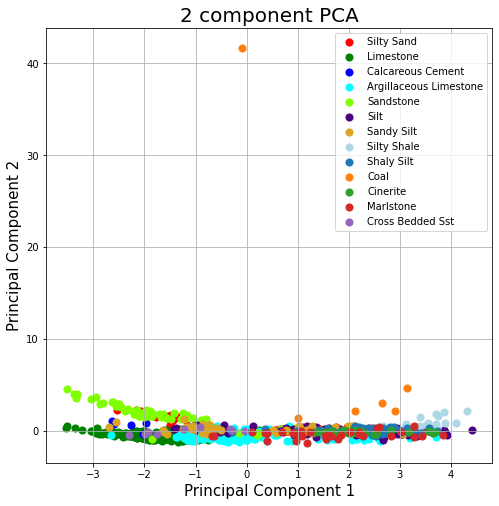

In [14]:
colors = [
    "r",
    "g",
    "b",
    "aqua",
    "chartreuse",
    "indigo",
    "goldenrod",
    "lightblue",
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Principal Component 1", fontsize=15)
ax.set_ylabel("Principal Component 2", fontsize=15)
ax.set_title("2 component PCA", fontsize=20)
for target, color in zip(targets, colors):
    indicesToKeep = final_df["target"] == target
    ax.scatter(
        final_df.loc[indicesToKeep, "PCA 1"],
        final_df.loc[indicesToKeep, "PCA 2"],
        c=color,
        s=50,
    )
ax.legend(targets)
ax.grid()

<a name="3-2"></a>
## 3.2 Linear Discriminar Analysis (LDA)

Linear discriminant analysis (LDA) finds a linear combination of features that separates two or more classes of objects or events. The resulting combination may be used as a linear classifier, or, more commonly, for **dimensionality reduction before later classification**.

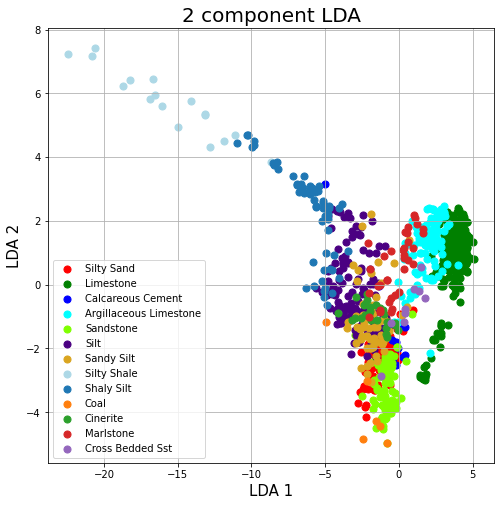

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda_X = lda.fit(X, y).transform(X)


lda_df = pd.DataFrame(data=lda_X, columns=["LDA 1", "LDA 2"])
# Concatenate two dataframes
final_df = pd.concat([lda_df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
# Rename column
final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
# List of lithologies in our dataset
targets = list(final_df["target"].unique())

# List of colors for the plot
colors = [
    "r",
    "g",
    "b",
    "aqua",
    "chartreuse",
    "indigo",
    "goldenrod",
    "lightblue",
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


# Plot Images
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("LDA 1", fontsize=15)
ax.set_ylabel("LDA 2", fontsize=15)
ax.set_title("2 component LDA", fontsize=20)
for target, color in zip(targets, colors):
    indicesToKeep = final_df["target"] == target
    ax.scatter(
        final_df.loc[indicesToKeep, "LDA 1"],
        final_df.loc[indicesToKeep, "LDA 2"],
        c=color,
        s=50,
    )
ax.legend(targets)
ax.grid()

<a name="3-3"></a>
## 3.3 Non-Negative Matrix Factorization (NMF)
Source: [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [16]:
print(X.max())
print(X.min())

31.40748833032305
-5.8146345450274834


In order to use NMF, our data cannot contain negative values. For that reason, we wil use `MinMaxScaler` from sklearn which scales the data in a given range. For example, range (0,1).

`MinMaxScaler` is equivalent to the code below:

```python
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X_transformed = scaler.transform(X)

In [18]:
print(X_transformed.max())
print(X_transformed.min())

1.0000000000000002
0.0


In [19]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2, init="random", random_state=2020)
nmf_X = nmf.fit_transform(X_transformed)

In [20]:
nmf_X.shape

(1000, 2)

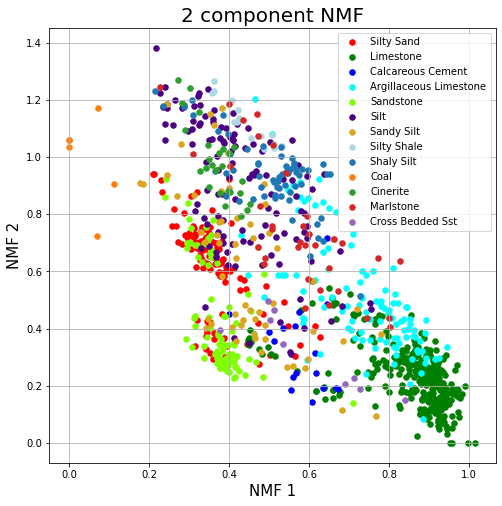

In [21]:
nmf_df = pd.DataFrame(data=nmf_X, columns=["NMF 1", "NMF 2"])
# Concatenate two dataframes
final_df = pd.concat([nmf_df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
# Rename column
final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
# List of lithologies in our dataset
targets = list(final_df["target"].unique())

# List of colors for the plot
colors = [
    "r",
    "g",
    "b",
    "aqua",
    "chartreuse",
    "indigo",
    "goldenrod",
    "lightblue",
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


# Plot Images
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("NMF 1", fontsize=15)
ax.set_ylabel("NMF 2", fontsize=15)
ax.set_title("2 component NMF", fontsize=20)
for target, color in zip(targets, colors):
    indicesToKeep = final_df["target"] == target
    ax.scatter(
        final_df.loc[indicesToKeep, "NMF 1"],
        final_df.loc[indicesToKeep, "NMF 2"],
        c=color,
        s=30,
    )
ax.legend(targets)
ax.grid()

<a name="3-4"></a>
## 3.4 Kernel PCA

Source: [Wikipedia](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis)
> In the field of multivariate statistics, kernel principal component analysis (kernel PCA) is an extension of principal component analysis (PCA) using techniques of kernel methods.


Source: [Sklearn](https://scikit-learn.org/stable/modules/metrics.html#metrics)

**Kernels**:
> Kernels are measures of similarity, i.e. `s(a, b) > s(a, c)` if objects `a` and `b` are considered “more similar” than objects `a` and `c`. A kernel must also be positive semi-definite.

In [22]:
from sklearn.decomposition import KernelPCA


def kernel_pca(X, kernel):
    transformer = KernelPCA(n_components=2, kernel=kernel)
    X_transformed = transformer.fit_transform(X)

    df = pd.DataFrame(data=X_transformed, columns=["K_PCA 1", "K_PCA 2"])
    # Concatenate two dataframes
    final_df = pd.concat([df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
    # Rename column
    final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
    # List of lithologies in our dataset
    targets = list(final_df["target"].unique())

    # List of colors for the plot
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]

    # Plot Images
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("K_PCA 1", fontsize=15)
    ax.set_ylabel("K_PCA 2", fontsize=15)
    ax.set_title('2 component KPCA using kernel={}'.format(kernel), fontsize=20)
    for target, color in zip(targets, colors):
        indicesToKeep = final_df["target"] == target
        ax.scatter(
            final_df.loc[indicesToKeep, "K_PCA 1"],
            final_df.loc[indicesToKeep, "K_PCA 2"],
            c=color,
            s=30,
        )
    ax.legend(targets)
    ax.grid()

Let's reduce the dimensions of the data using different kernels.



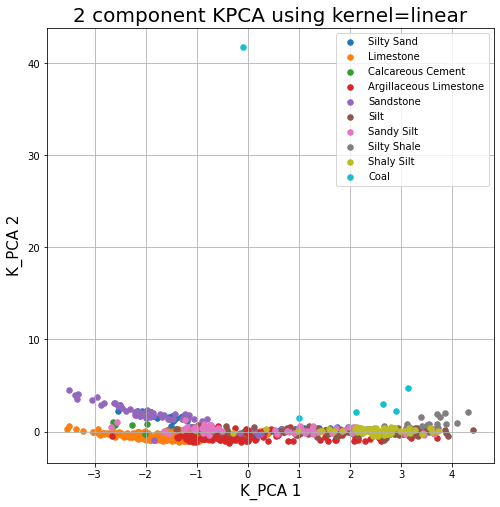

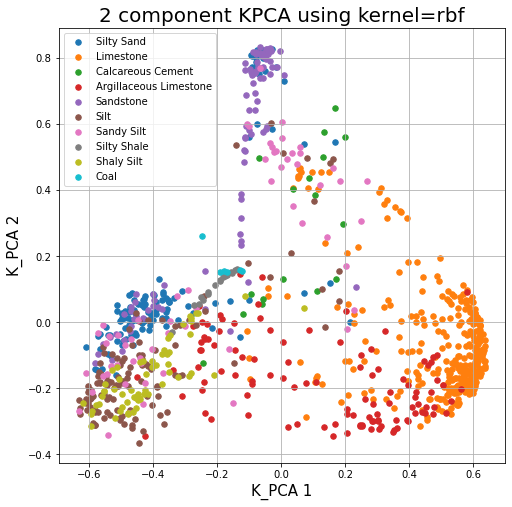

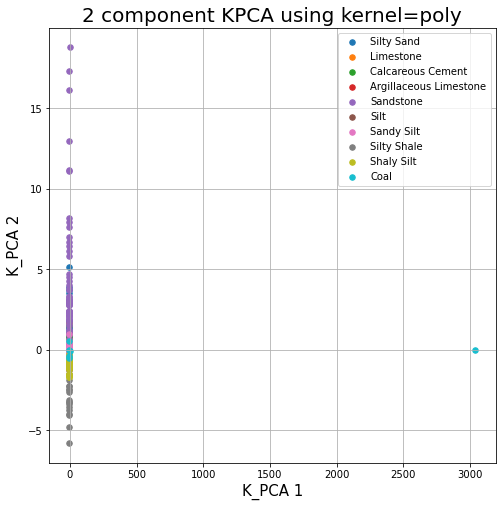

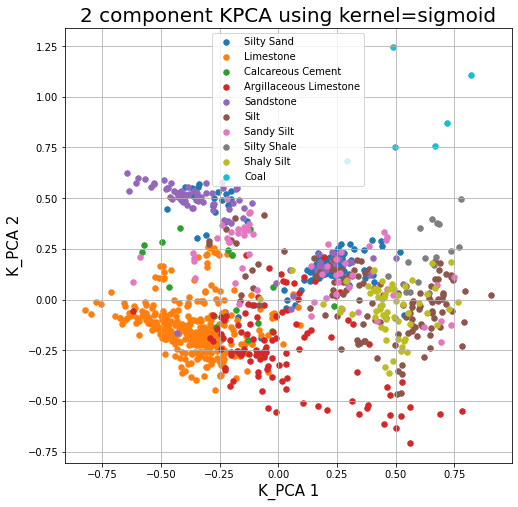

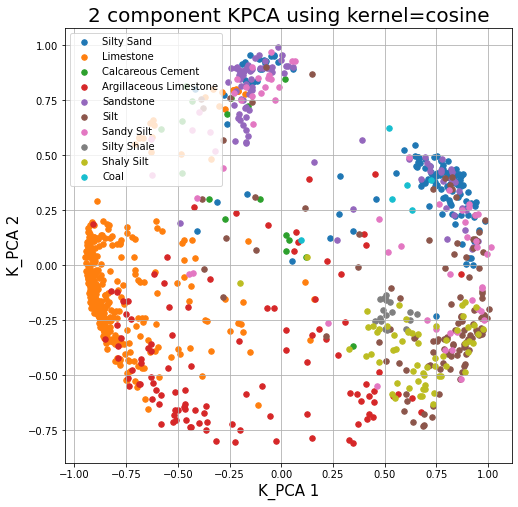

In [23]:
kernels = ["linear", "rbf", "poly", "sigmoid", "cosine"]

for kernel in kernels:
    kernel_pca(X, kernel)

<a name="3-5"></a>
## 3.5 tSNE

T-distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised learning developed specificaly for data visualization. This tecnique embedded high-dimensional data in a low-dimensional space of two or three dimensions. Therefore, the embedding or representation of the manifold can be visualize in 2 or 3 dimensions.

Let's try something similar to what we did before using now the tSNE technique.

In [24]:
from sklearn.manifold import TSNE

tsne_X = TSNE(n_components=2).fit_transform(X)
tsne_X

array([[ 32.14491  ,  -1.32292  ],
       [-27.572634 ,  20.120937 ],
       [-29.67436  , -12.130145 ],
       ...,
       [ 31.924376 ,   4.151333 ],
       [ 22.16679  , -22.701136 ],
       [  1.3150626,  16.361738 ]], dtype=float32)

In [25]:
tnse_df = pd.DataFrame(data=tsne_X, columns=["TNSE 1", "TNSE 2"])
tnse_df.head()

,TNSE 1,TNSE 2
0,32.144909,-1.322920
1,-27.572634,20.120937
2,-29.674360,-12.130145
3,23.940016,11.739909
4,-42.292713,-28.283138


In [26]:
y.reset_index()["LITHOLOGY_GEOLINK"]

0                  Silty Sand
1                   Limestone
2           Calcareous Cement
3      Argillaceous Limestone
4                   Sandstone
                ...          
995                 Limestone
996                 Sandstone
997                Silty Sand
998                      Silt
999    Argillaceous Limestone
Name: LITHOLOGY_GEOLINK, Length: 1000, dtype: category
Categories (26, object): ['Anhydrite', 'Argillaceous Limestone', 'Calcareous Cement', 'Carnallite', ..., 'Silt', 'Silty Sand', 'Silty Shale', 'Volcanic Tuff']

In [27]:
# Concat two columns
final_df = pd.concat([tnse_df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
# Rename column target
final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
final_df.head()

,TNSE 1,TNSE 2,target
0,32.144909,-1.322920,Silty Sand
1,-27.572634,20.120937,Limestone
2,-29.674360,-12.130145,Calcareous Cement
3,23.940016,11.739909,Argillaceous Limestone
4,-42.292713,-28.283138,Sandstone


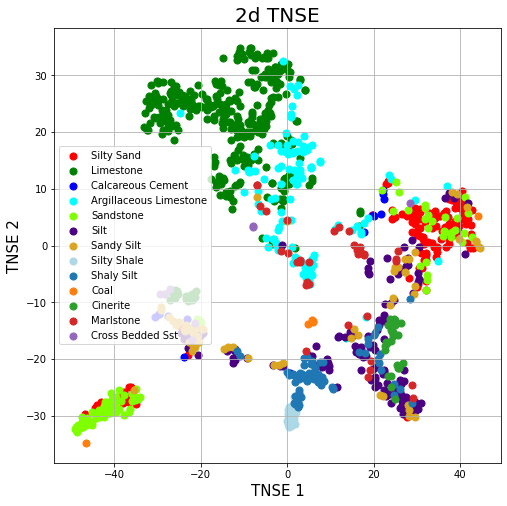

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("TNSE 1", fontsize=15)
ax.set_ylabel("TNSE 2", fontsize=15)
ax.set_title("2d TNSE", fontsize=20)

for target, color in zip(targets, colors):
    indicesToKeep = final_df["target"] == target
    ax.scatter(
        final_df.loc[indicesToKeep, "TNSE 1"],
        final_df.loc[indicesToKeep, "TNSE 2"],
        c=color,
        s=50,
    )
ax.legend(targets)
ax.grid()

<a name="3-6"></a>
## 3.6 ISOMAP

Isomap is a popular technique for dimensionality reduction. Isomap is a highly efficient algorithm and it can be generally applied to a variety of data sources and dimensionalities.

In [29]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
isomap_X = isomap.fit_transform(X)

# Isomap Dataframe
isomap_df = pd.DataFrame(data=isomap_X, columns=["ISOMAP 1", "ISOMAP 2"])
# Concat two columns
final_df = pd.concat([isomap_df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
# Rename column target
final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
final_df.head()

,ISOMAP 1,ISOMAP 2,target
0,-1.517167,2.371877,Silty Sand
1,2.708323,-2.848101,Limestone
2,6.325503,0.111220,Calcareous Cement
3,0.086510,0.496740,Argillaceous Limestone
4,7.928754,4.828528,Sandstone


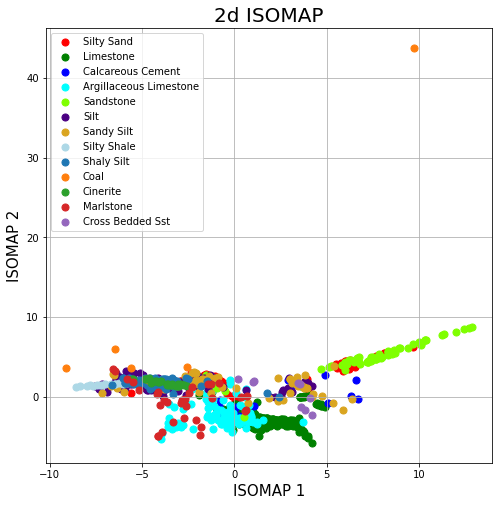

In [30]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("ISOMAP 1", fontsize=15)
ax.set_ylabel("ISOMAP 2", fontsize=15)
ax.set_title("2d ISOMAP", fontsize=20)

for target, color in zip(targets, colors):
    indicesToKeep = final_df["target"] == target
    ax.scatter(
        final_df.loc[indicesToKeep, "ISOMAP 1"],
        final_df.loc[indicesToKeep, "ISOMAP 2"],
        c=color,
        s=50,
    )
ax.legend(targets)
ax.grid()

<div class="alert alert-success" style="font-size:100%">

  <h2>Exercise 1:</h2><br/>
  Plot a 2d PCA for a different well log:

  1. Select the well log '16_7-4' and sample 1000 points.
  2. Apply PCA using 2 components.
  3. Preprocess data and plot a 2-dimensional representation of the data.
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
    ########################################################################
    # SELECT A DIFFERENT WELL LOG
    ########################################################################
    # Sample the data points
    sample_dataset_2 = geolink.xs('16_7-4').sample(n=1000, replace=False, random_state=2020)
    # Separating features
    X_2 = sample_dataset_2[list(sample_dataset_2.columns[1:])]
    # Separating target
    y_2 = sample_dataset_2[["LITHOLOGY_GEOLINK"]]
    # Standardizing the features
    X_2 = StandardScaler().fit_transform(X_2)
    ########################################################################
    # FIT DATA USING PCA
    ########################################################################
    # We will use 2 components so we can later use a 2d plot.
    pca_2 = PCA(n_components=2)
    # We are reducing the dimensions in this step from 6 features to only 2
    pca_X_2 = pca.fit_transform(X_2)
    ########################################################################
    # PREPROCESS DATA
    ########################################################################
    pca_df_2 = pd.DataFrame(data=pca_X_2, columns=["PCA 1", "PCA 2"])
    # Concatenate two dataframes
    final_df_2 = pd.concat([pca_df_2, y_2.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
    # Rename column
    final_df_2 = final_df_2.rename(columns={"LITHOLOGY_GEOLINK": "target"})
    # List of lithologies in our dataset
    targets_2 = list(final_df_2["target"].unique())
    ########################################################################
    # VISUALIZE DATA
    ########################################################################
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("PCA 1", fontsize=15)
    ax.set_ylabel("PCA 2", fontsize=15)
    ax.set_title("2d PCA", fontsize=20)

    for target, color in zip(targets_2, colors):
        indicesToKeep = final_df_2["target"] == target
        ax.scatter(
            final_df_2.loc[indicesToKeep, "PCA 1"],
            final_df_2.loc[indicesToKeep, "PCA 2"],
            c=color,
            s=50,
        )
    ax.legend(targets_2)
    ax.grid()
  ```
  </details>
    
</div>

## 3.7 UMAP

From the [offcial documentation](https://umap-learn.readthedocs.io/en/latest/):

> Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data
- The data is uniformly distributed on Riemannian manifold
- The Riemannian metric is locally constant (or can be approximated as such)
- The manifold is locally connected. <br/><br/>
From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

In [31]:
# Import umap
import umap

reducer = umap.UMAP(n_components=2, random_state=2020)
umap_X = reducer.fit_transform(X)

# Isomap Dataframe
umap_df = pd.DataFrame(data=umap_X, columns=["UMAP 1", "UMAP 2"])
# Concat two columns
final_df = pd.concat([umap_df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
# Rename column target
final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
final_df.head()

,UMAP 1,UMAP 2,target
0,12.589117,5.470096,Silty Sand
1,11.852802,14.470120,Limestone
2,2.962461,4.914433,Calcareous Cement
3,13.242313,7.100631,Argillaceous Limestone
4,-1.344305,4.097811,Sandstone


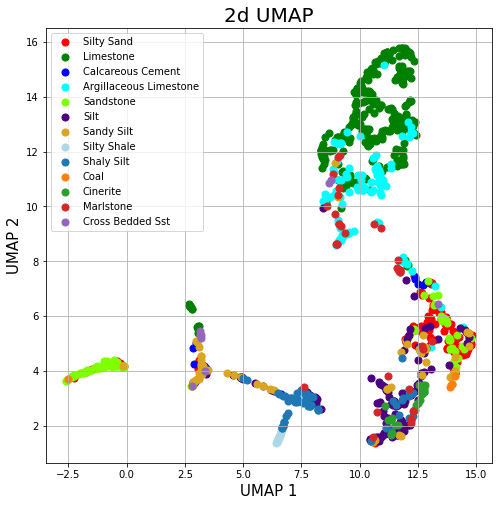

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("UMAP 1", fontsize=15)
ax.set_ylabel("UMAP 2", fontsize=15)
ax.set_title("2d UMAP", fontsize=20)

for target, color in zip(targets, colors):
    indicesToKeep = final_df["target"] == target
    ax.scatter(
        final_df.loc[indicesToKeep, "UMAP 1"],
        final_df.loc[indicesToKeep, "UMAP 2"],
        c=color,
        s=50,
    )
ax.legend(targets)
ax.grid()

 <a name="4"></a>
# 4. Clustering

> Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). It is a main task of exploratory data mining, and a common technique for statistical data analysis, used in many fields, including pattern recognition, image analysis, information retrieval, bioinformatics, data compression, computer graphics and machine learning. Cluster analysis itself is not one specific algorithm, but the general task to be solved...

Source: [Wikipedia](https://en.wikipedia.org/wiki/Cluster_analysis)


<div class="alert alert-info" style="font-size:100%">

**NOTE:** <br>
Different clustering algorithms have different properties. The example below (Source: [Sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)) shows characteristics of different clustering algorithms on datasets that are “interesting” but still in 2D. With the exception of the last dataset, the parameters of each of these dataset-algorithm pairs has been tuned to produce good clustering results. Some algorithms are more sensitive to parameter values than others.
    
**Warning:** While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data.
    
</div>



<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png' width=800 heigh=800/>



You can explore many different clustering algorithm. They usually have a very similar API in `sklearn` library.

<a name="4-1"></a>
## 4.1 KMeans

Kmeans is a clustering algorithm where given a k number of clusters, it tries to find the centroid with the nearest mean.

In the example below, we have some data in a 2d space with 3 clusters. The algorithm will find the best centroids for the 3 clusters in a iterative process:

![kmeans-convergence](https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif)

[Image Source](https://en.wikipedia.org/wiki/K-means_clustering#/media/File:K-means_convergence.gif) License Image: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

**How to choose the right number of clusters?**

We will use the **Elbow Method**:

Using the "elbow" as a cutoff point is a common heuristic to choose a number of cluster where that adding another cluster doesn't give much better modeling of the data.

Let's reduce the dimensions first using TSNE and then we will apply the Kmeans algorithm.

In [33]:
tsne_X = TSNE(n_components=2).fit_transform(X)
tnse_df = pd.DataFrame(data=tsne_X, columns=["TNSE 1", "TNSE 2"])
# Concat two columns
final_df = pd.concat([tnse_df, y.reset_index()["LITHOLOGY_GEOLINK"]], axis=1)
# Rename column target
final_df = final_df.rename(columns={"LITHOLOGY_GEOLINK": "target"})
final_df.head()

,TNSE 1,TNSE 2,target
0,2.355762,31.387901,Silty Sand
1,14.263649,-29.576721,Limestone
2,-18.622616,-25.635429,Calcareous Cement
3,14.195963,21.954496,Argillaceous Limestone
4,-34.791157,-34.255104,Sandstone


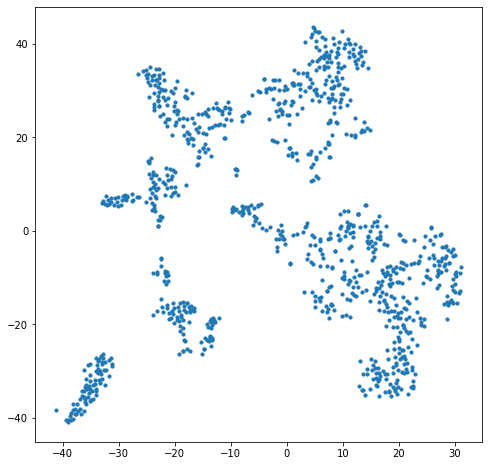

In [34]:
# Plot Manifold
plt.figure(figsize=(8, 8))
plt.scatter(final_df["TNSE 1"], final_df["TNSE 2"], s=10)

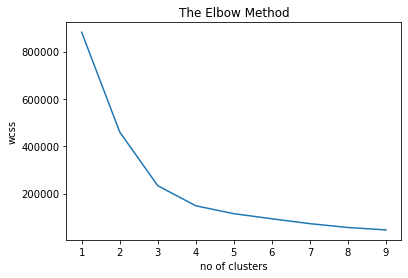

In [35]:
from sklearn.cluster import KMeans

inertia = []
# we will say that the number of clusters is 10 (total number of different lithologies)
### Static code to get max no of clusters
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=2020)
    kmeans.fit(final_df[["TNSE 1", "TNSE 2"]])
    inertia.append(kmeans.inertia_)
    # inertia_ is the formula used to segregate the data points into clusters

# Visualizing the ELBOW method to get the optimal value of K
plt.plot(range(1, 10), inertia)
plt.title("The Elbow Method")
plt.xlabel("no of clusters")
plt.ylabel("wcss")
plt.show()

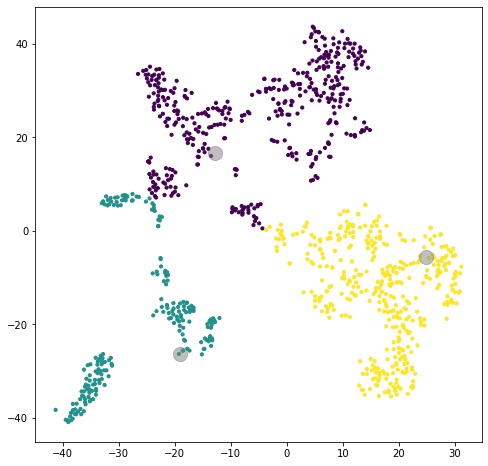

In [36]:
# Model Build
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=2020)
y_kmeans = kmeans.fit_predict(final_df[["TNSE 2", "TNSE 1"]])
# Plot the different clusters
plt.figure(figsize=(8, 8))
plt.scatter(final_df["TNSE 1"], final_df["TNSE 2"], c=y_kmeans, s=10, cmap="viridis")
centers = kmeans.cluster_centers_
# Plot the centers
plt.scatter(centers[:, 0], centers[:, 1], c="gray", s=200, alpha=0.5)

<a name="4-2"></a>
## 4.2 DBScan

Density-based spatial clustering of applications with noise (DBSCAN) is a very popular clustering algorithm, which has been reconognized both in the academy and industry as one of the most used methods for industrial applications and most cited clustering algorithms in scientific literature.

One of the reasons that makes DBSCAN a great method for clustering is that also helps to estimate the optimal number of cluster in the data.

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/DBSCAN-density-data.svg/1920px-DBSCAN-density-data.svg.png' width=400 heigh=400>

License Image: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)


For the next example we will use the sample data. Source: [Sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)

In [37]:
# Import DBSCAN
from sklearn.cluster import DBSCAN

# Helpers to generate data around the centers
from sklearn.datasets import make_blobs

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

Now we will compute DBScan:

In [38]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 18


DBScan assigns a cluster (positive numeric) label to each data point and -1 if it is considered noise.

In [39]:
print(db.labels_)

[ 0  1  0  2  0  1  1  2  0  0  1  1  1  2  1  0 -1  1  1  2  2  2  2  2
  1  1  2  0  0  2  0  1  1  0  1  0  2  0  0  2  2  1  1  1  1  1  0  2
  0  1  2  2  1  1  2  2  1  0  2  1  2  2  2  2  2  0  2  2  0  0  0  2
  0  0  2  1 -1  1  0  2  1  1  0  0  0  0  1  2  1  2  2  0  1  0  1 -1
  1  1  0  0  2  1  2  0  2  2  2  2 -1  0 -1  1  1  1  1  0  0  1  0  1
  2  1  0  0  1  2  1  0  0  2  0  2  2  2  0 -1  2  2  0  1  0  2  0  0
  2  2 -1  2  1 -1  2  1  1  2  2  2  0  1  0  1  0  1  0  2  2 -1  1  2
  2  1  0  1  2  2  2  1  1  2  2  0  1  2  0  0  2  0  0  1  0  1  0  1
  1  2  2  0  0  1  1  2  1  2  2  2  2  0  2  0  2  2  0  2  2  2  0  0
  1  1  1  2  2  2  2  1  2  2  0  0  2  0  0  0  1  0  1  1  1  2  1  1
  0  1  2  2  1  2  2  1  0  0  1  1  1  0  1  0  2  0  2  2  2  2  2  1
  1  0  0  1  1  0  0  2  1 -1  2  1  1  2  1  2  0  2  2  0  1  2  2  0
  2  2  0  0  2  0  2  0  2  1  0  0  0  1  2  1  2  2  0  2  2  0  0  2
  1  1  1  1  1  0  1  1  1  1  0  0  1  1  1  0  2

DBScan will help us to determine the number of clusters in our data manifold.

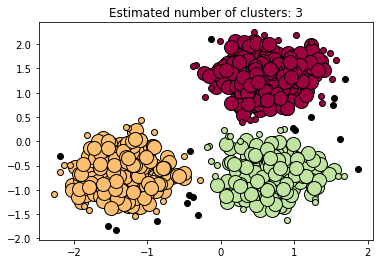

In [40]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# References and further reading

[Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning)

[Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)

Clustering:
- [K-means](https://en.wikipedia.org/wiki/K-means_clustering)
- [DBScan](https://en.wikipedia.org/wiki/DBSCAN)
- [Hierarchical Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)